In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# CHEKING DISK STORAGE

In [2]:
import shutil

# Get disk space details
total, used, free = shutil.disk_usage("/")

# Convert to human-readable format
def format_size(size):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024

print()
print(f"Total Space: {format_size(total)}")
print(f"Used Space: {format_size(used)}")
print(f"Free Space: {format_size(free)}")
print()


Total Space: 915.32 GB
Used Space: 781.94 GB
Free Space: 86.82 GB



In [3]:
import os

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            # Add file size, skipping broken symbolic links
            if os.path.exists(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

def print_directory_size(directory):
    size_bytes = get_directory_size(directory)
    # Convert bytes to a human-readable format (KB, MB, GB)
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024:
            print(f"Size of '{directory}': {size_bytes:.2f} {unit}")
            break
        size_bytes /= 1024

print()
# Example usage
preprocessed_files_path = "data/train_data/preprocessed_files"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

preprocessed_files_path = "executions"  # Change this to your target directory
print_directory_size(preprocessed_files_path)
print()


Size of 'data/train_data/preprocessed_files': 3.49 GB
Size of 'executions': 8.41 GB



# SPECIFY EXECUTION ID TO EVALUATE


In [4]:
import os

############### EXECUTION SETTINGS ###############

PARENT_EXECUTION_DIR = "executions/unet/tuning-train-test"

############## EXECUTION ID ######################

EXECUTION_ID = 171 # Update ID

execution_dir = os.path.join(PARENT_EXECUTION_DIR, f"id={EXECUTION_ID}")
print()
print(f"Execution to evaluate: {execution_dir}")
print()


Execution to evaluate: executions/unet/tuning-train-test/id=171



# LOAD EXECUTION SETTINGS

In [5]:
import json
import pprint

# Load JSON
info_execution_json_file_path = os.path.join(execution_dir, "info_execution.json")

with open(info_execution_json_file_path, "r") as json_file:
    info_execution = json.load(json_file)

# pprint.pprint(info_execution, sort_dicts=False, width=100)
print(info_execution)
print()

################### DATA SETTINGS #################

DATA_DIR = info_execution["DATA_SETTINGS"]["DATA_DIR"] 
# Directory where the samples (data and labels folders) and the metadata.json file are located.

NUM_WORKERS = info_execution["DATA_SETTINGS"]["NUM_WORKERS"]
# Number of logical CPU Cores used for parallelizing data laoding


{'INFO_EXECUTION': {'PARENT_EXECUTION_DIR': 'executions/unet/tuning-train-test', 'EXECUTION_ID': 171, 'EXECUTION_DIR': 'id=171'}, 'DATA_SETTINGS': {'DATA_DIR': 'data/train_data', 'METADATA_DATASET': 'metadata_37_samples.json', 'K_FOLDS': 6, 'NUM_WORKERS': 4, 'SAMPLES_DATASET': ['R_002', 'R_003', 'R_004', 'R_005', 'R_006', 'R_007', 'R_008', 'R_009', 'R_010', 'R_011', 'R_012', 'R_013', 'R_014', 'R_015', 'R_016', 'R_017', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_004', 'Z_005', 'Z_006', 'Z_007', 'Z_008', 'Z_009', 'Z_010', 'Z_011', 'Z_012', 'Z_013', 'Z_014', 'Z_015', 'Z_016', 'Z_017', 'Z_018', 'Z_019', 'Z_020'], 'VALIDATION_SET': ['R_002', 'R_003', 'R_011', 'Z_005', 'Z_008', 'Z_014', 'Z_020'], 'TRAIN_TEST_SPLITS': {'SPLIT_0': {'TRAIN_SET': ['R_004', 'R_005', 'R_007', 'R_008', 'R_009', 'R_013', 'R_014', 'R_015', 'R_016', 'R_017', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_006', 'Z_007', 'Z_009', 'Z_010', 'Z_011', 'Z_012', 'Z_015', 'Z_016', 'Z_018', 'Z_019'], 'TEST_SET': ['R_006', 'R_010', 'R_012',

# LOAD DATA SPLITTING INFO

In [6]:
import json
import os


# Load metadata JSON file
metadata_json_path = os.path.join(info_execution["DATA_SETTINGS"]["DATA_DIR"], info_execution["DATA_SETTINGS"]["METADATA_DATASET"])
with open(metadata_json_path, "r") as f:
    metadata = json.load(f)

# Restore validation files
validation_files_original_copy = {sample: metadata[sample] for sample in info_execution["DATA_SETTINGS"]["VALIDATION_SET"]}

# Restore train-test splits
train_test_splits_orginal_copy = []
for split_key, split_data in info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"].items():
    train_files = {sample: metadata[sample] for sample in split_data["TRAIN_SET"]}
    test_files = {sample: metadata[sample] for sample in split_data["TEST_SET"]}
    train_test_splits_orginal_copy.append((train_files, test_files))

print("✅ Successfully restored `train_test_splits_orginal_copy` and `validation_files_original_copy` from JSON!")

print()

✅ Successfully restored `train_test_splits_orginal_copy` and `validation_files_original_copy` from JSON!



# Import UNET_VGG11 LIGHTNING MODEL

In [7]:
import importlib
from models.unet import UNET_VGG11_lightning_model

# Reload the module (if necessary)
importlib.reload(UNET_VGG11_lightning_model)

# Import the class from the reloaded module
from models.unet.UNET_VGG11_lightning_model import UNET_VGG11_LightningModel
print()

All imports succeeded!
All imports succeeded!



# Import UNET_VGG11 DATASET

In [8]:
import importlib
from models.unet import UNET_VGG11_dataset

# Reload the module (if necessary)
importlib.reload(UNET_VGG11_dataset)

# Import the class from the reloaded module
from models.unet.UNET_VGG11_dataset import UNET_VGG11_Dataset
print()

All imports succeeded!
All imports succeeded!



# Importing libraries

In [9]:
import os
import json
import time
import shutil
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns  # Used for plotting
from PIL import Image  # Used to save images
from datetime import timedelta, datetime
from sklearn.metrics import auc, confusion_matrix

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import optuna

# Functions needed

In [10]:
import importlib
# Own library
import utils.data_utils
importlib.reload(utils.data_utils)
from utils.data_utils import custom_collate

# Function to apply the viridis colormap and convert to uint8
def apply_colormap_and_normalize(array, cmap, vmin, vmax):
    norm_array = (array - vmin) / (vmax - vmin)  # Normalize to [0, 1]
    norm_array = np.clip(norm_array, 0, 1)  # Clip values to avoid overflow
    colormap = plt.get_cmap(cmap)
    rgba_img = colormap(norm_array)  # Apply colormap, returns RGBA
    rgb_img = (rgba_img[:, :, :3] * 255).astype("uint8")  # Convert to RGB
    return rgb_img

# BEST TRIAL IN STUDY

## Summary

In [11]:
tuning_dir = os.path.join(execution_dir, 'tuning')
best_trial_json_path = os.path.join(tuning_dir, "best_trial", "best_trial_summary_info.json")

# Load JSON
with open(best_trial_json_path, "r") as json_file:
    best_trial_config = json.load(json_file)

# Extract the best trial number and validation loss
best_trial_info = best_trial_config.get("MODEL_INFO", {})
best_trial_training_config = best_trial_config.get("TRAINING_CONFIG", {})

val_loss = best_trial_config.get("VAL_LOSS")
val_loss = float(val_loss) if isinstance(val_loss, (int, float)) else None  # Convert only if it's a number

print()
print(f"{'=' * 50}")
print(f"{'=' * 18} BEST TRIAL: {best_trial_config.get('TRIAL_ID', 'N/A')} {'=' * 17}")
print(f"{'=' * 16} Val. Loss: {val_loss:.4f} {'=' * 16}" if val_loss is not None else f"{'=' * 16} Val. Loss: N/A {'=' * 16}")
print(f"{'=' * 50}")
print()

print(f"Total Parameters: {best_trial_info.get('model_total_params', 'N/A')}")
print(f"Trainable Parameters: {best_trial_info.get('model_trainable_params', 'N/A')}")
print(f"Non-Trainable Parameters: {best_trial_info.get('model_non_trainable_params', 'N/A')}")
print(f"FLOPs: {best_trial_info.get('model_gflops_inference', 0.0):.3f} GFLOPs")
print()
print()

# Pretty-print the configurations
pprint.pprint(best_trial_config, sort_dicts=False, width=100)

print()


================== BEST TRIAL: 299 =================
================ Val. Loss: 0.1303 ================

Total Parameters: 28318466
Trainable Parameters: 28318466
Non-Trainable Parameters: 0
FLOPs: 75.842 GFLOPs


{'TRIAL_ID': 299,
 'VAL_LOSS': 0.1303325593471527,
 'MODEL_INFO': {'model_total_params': 28318466,
                'model_trainable_params': 28318466,
                'model_non_trainable_params': 0,
                'model_gflops_inference': 75.842077696},
 'TRAINING_CONFIG': {'lr_optimizer': 0.0033250234238817035,
                     'weight_decay_optimizer': 0.00010179319024552697,
                     'optimizer': 'adam',
                     'max_training_epochs': 3000,
                     'patience_epochs_early_stopping': 578,
                     'batch_size': 8,
                     'pre_processing_technique': 'ppt',
                     'pre_processing_channels': 10}}



## Validation Results (Ground Truth vs Prediction)

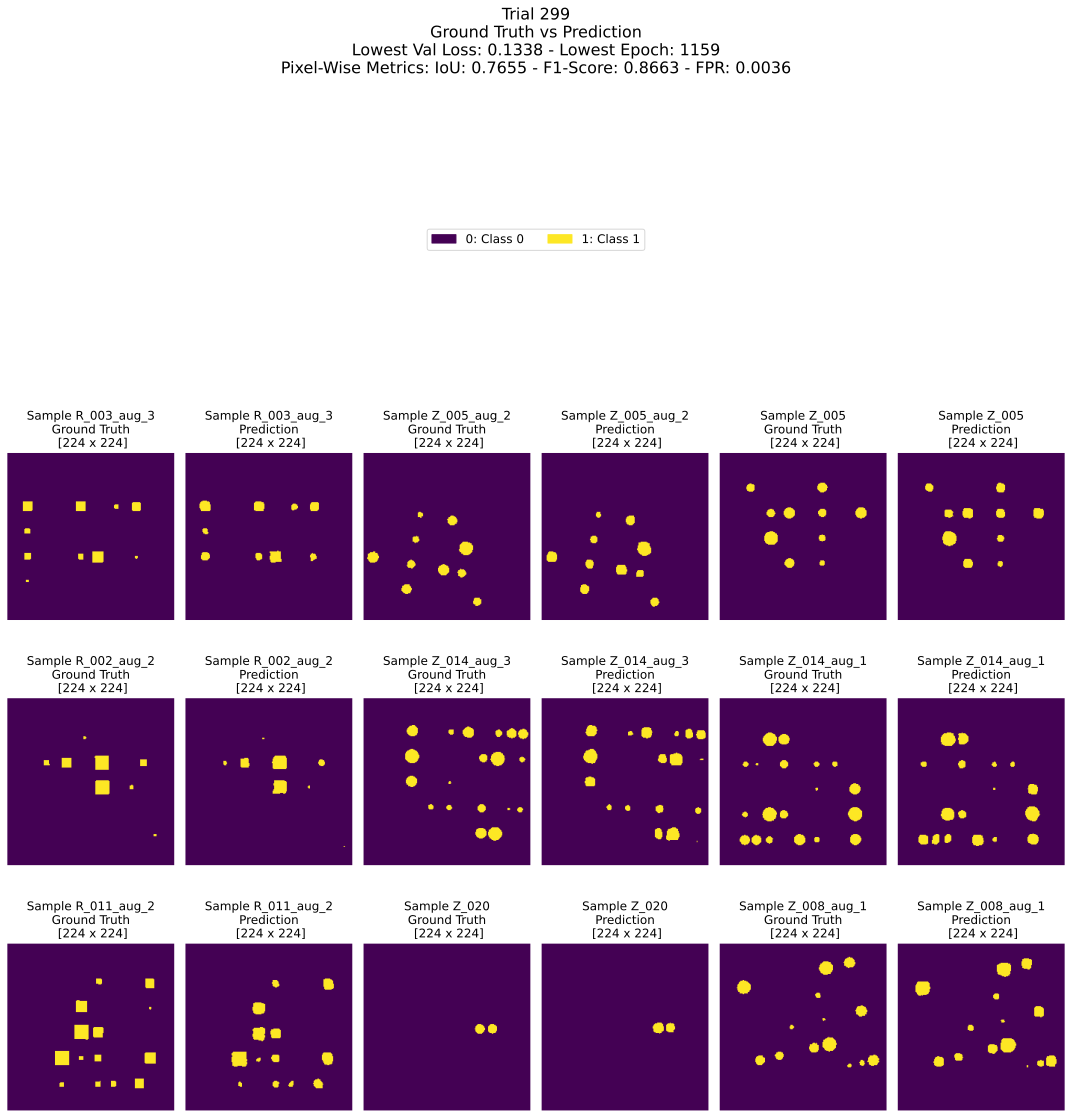

In [12]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"validation_gt_vs_pred.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path

## Training vs Validation Loss Evolution

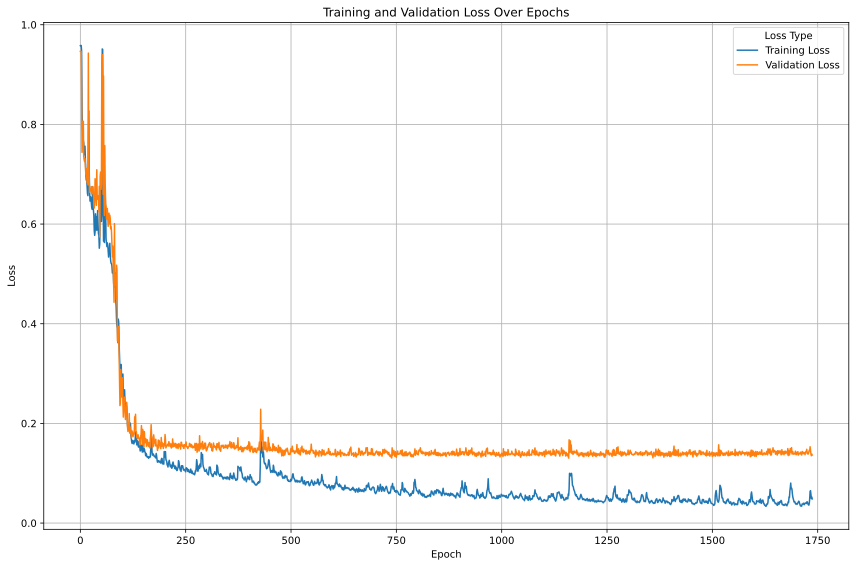

In [13]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"train_val_loss_evolution.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path

# EVALUATION

JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json
Evaluation (no training) starts at: 2025-04-12 20:29:14.499351


JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json

========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_006', 'R_010', 'R_012', 'Z_004', 'Z_013', 'Z_017'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_006 ...


R_006 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_010 ...


R_010 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_012 ...


R_012 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_004 ...


Z_004 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_013 ...


Z_013 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_017 ...


Z_017 preprocessed (preprocessing took 0.00 seconds)


The JSON file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/preprocessed_info.json' has been updated.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory executions/unet/tuning-train-test/id=171/train_test_split_0/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Testing: |                                                                                                    …

Starting testing epoch...

==> (TESTING) Average Dice Loss (include_background=[False]): 0.132043

==> (TESTING) Average Pixel-Wise Mean IoU (include_background=[False]): 0.768713

==> (TESTING) Average Pixel-Wise Dice Coefficient (include_background=[False]): 0.867863

==> (TESTING) Average Pixel-Wise FPR (include_background=[False]): 0.003390

==> (TESTING) Average TPR/Recall (include_background=[False]): 0.862656

==> (TESTING) Average Precision (include_background=[False]): 0.887385

Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.8678627014160156
     test_fpr_epoch        0.0033902600407600403
     test_loss_epoch        0.13204306364059448
   test_mean_iou_epoch      0.7687131762504578
  test_

/tmp/ipykernel_98077/2782184094.py:291: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("viridis", num_classes)


Testing results plot for split 0 saved at: executions/unet/tuning-train-test/id=171/train_test_split_0/testing_results/testing_gt_vs_pred_split_0.svg


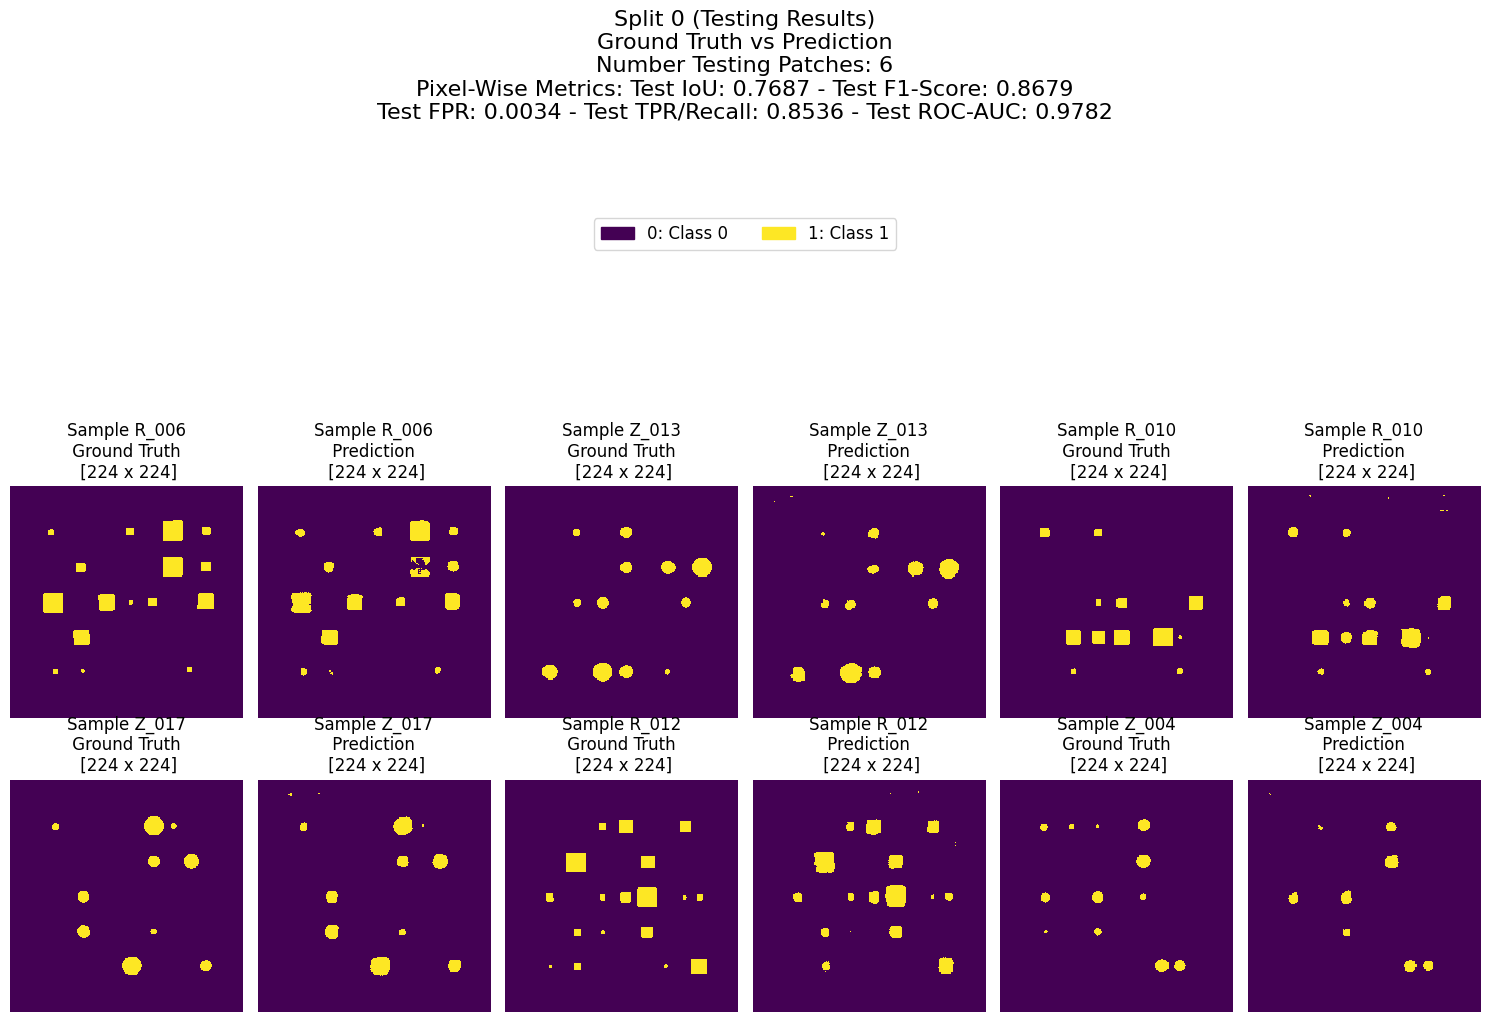

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json
JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json

========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_008', 'R_014', 'R_019', 'Z_011', 'Z_015', 'Z_016'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_008 ...


R_008 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_014 ...


R_014 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_019 ...


R_019 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_011 ...


Z_011 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_015 ...


Z_015 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_016 ...


Z_016 preprocessed (preprocessing took 0.00 seconds)


The JSON file '/home/adrian/AIRT_Seg

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory executions/unet/tuning-train-test/id=171/train_test_split_1/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Testing: |                                                                                                    …

Starting testing epoch...

==> (TESTING) Average Dice Loss (include_background=[False]): 0.181769

==> (TESTING) Average Pixel-Wise Mean IoU (include_background=[False]): 0.701932

==> (TESTING) Average Pixel-Wise Dice Coefficient (include_background=[False]): 0.819672

==> (TESTING) Average Pixel-Wise FPR (include_background=[False]): 0.004123

==> (TESTING) Average TPR/Recall (include_background=[False]): 0.888621

==> (TESTING) Average Precision (include_background=[False]): 0.829062

Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.8196719288825989
     test_fpr_epoch        0.004123221151530743
     test_loss_epoch        0.1817694902420044
   test_mean_iou_epoch      0.7019317150115967
  test_pr

/tmp/ipykernel_98077/2782184094.py:291: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("viridis", num_classes)


Testing results plot for split 1 saved at: executions/unet/tuning-train-test/id=171/train_test_split_1/testing_results/testing_gt_vs_pred_split_1.svg


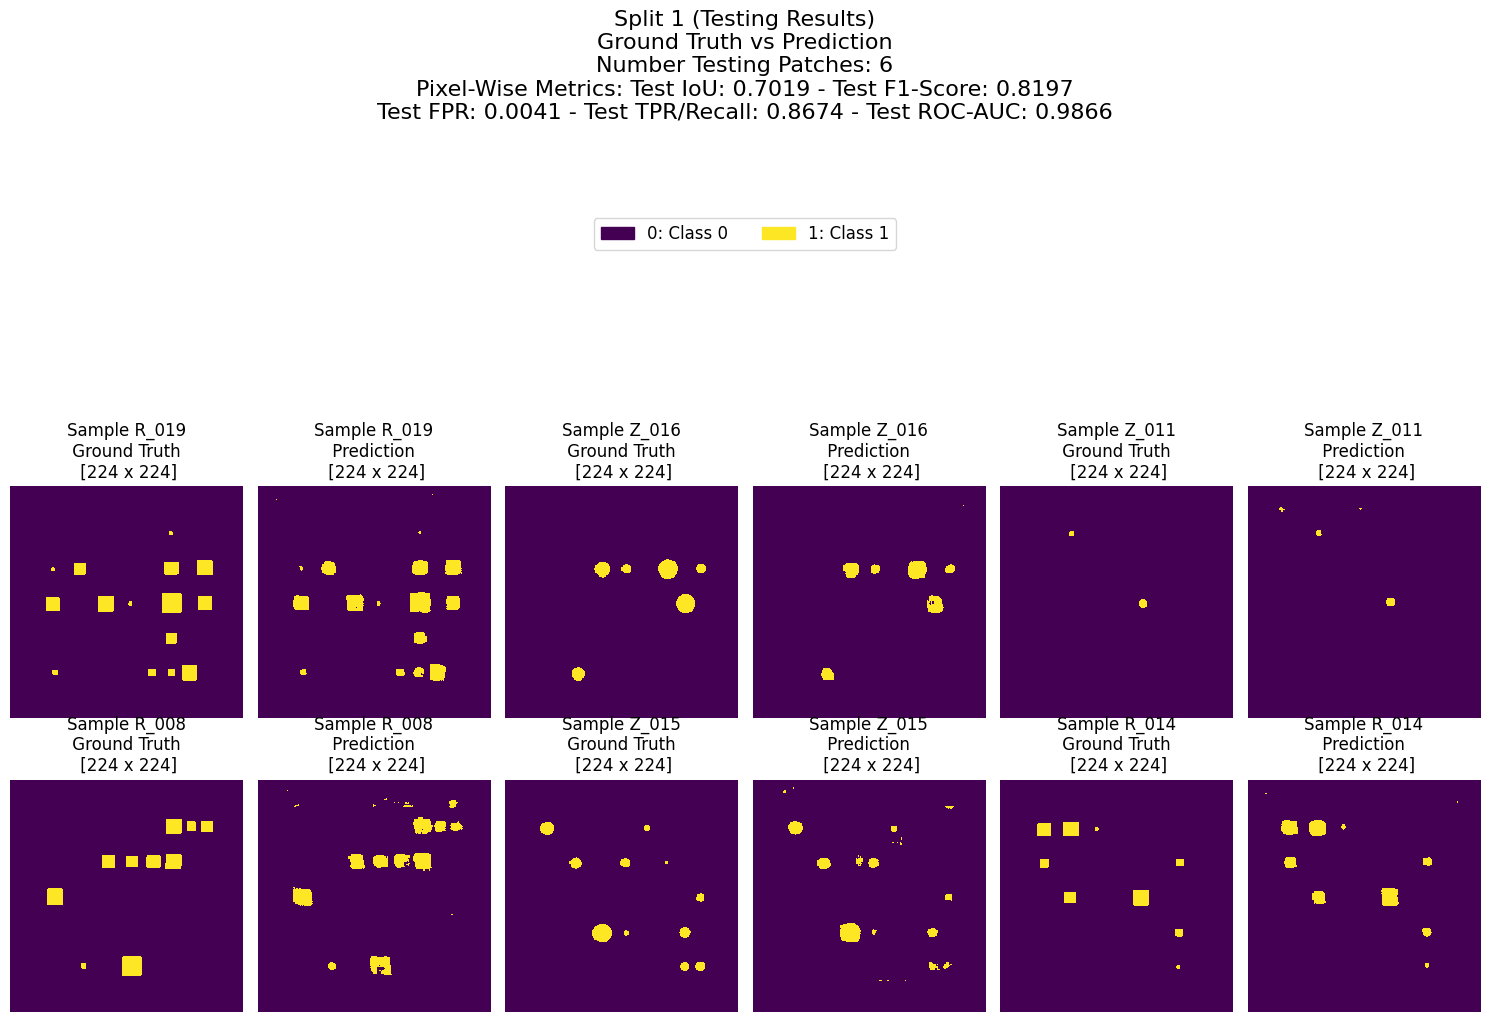

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json
JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json

========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_009', 'R_015', 'R_020', 'Z_006', 'Z_009', 'Z_019'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_009 ...


R_009 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_015 ...


R_015 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_020 ...


R_020 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_006 ...


Z_006 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_009 ...


Z_009 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_019 ...


Z_019 preprocessed (preprocessing took 0.00 seconds)


The JSON file '/home/adrian/AIRT_Seg

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory executions/unet/tuning-train-test/id=171/train_test_split_2/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Testing: |                                                                                                    …

Starting testing epoch...

==> (TESTING) Average Dice Loss (include_background=[False]): 0.191989

==> (TESTING) Average Pixel-Wise Mean IoU (include_background=[False]): 0.691236

==> (TESTING) Average Pixel-Wise Dice Coefficient (include_background=[False]): 0.809025

==> (TESTING) Average Pixel-Wise FPR (include_background=[False]): 0.004195

==> (TESTING) Average TPR/Recall (include_background=[False]): 0.803804

==> (TESTING) Average Precision (include_background=[False]): 0.786490

Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.8090254664421082
     test_fpr_epoch        0.004194625187665224
     test_loss_epoch        0.19198918342590332
   test_mean_iou_epoch      0.6912357211112976
  test_p

/tmp/ipykernel_98077/2782184094.py:291: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("viridis", num_classes)


Testing results plot for split 2 saved at: executions/unet/tuning-train-test/id=171/train_test_split_2/testing_results/testing_gt_vs_pred_split_2.svg


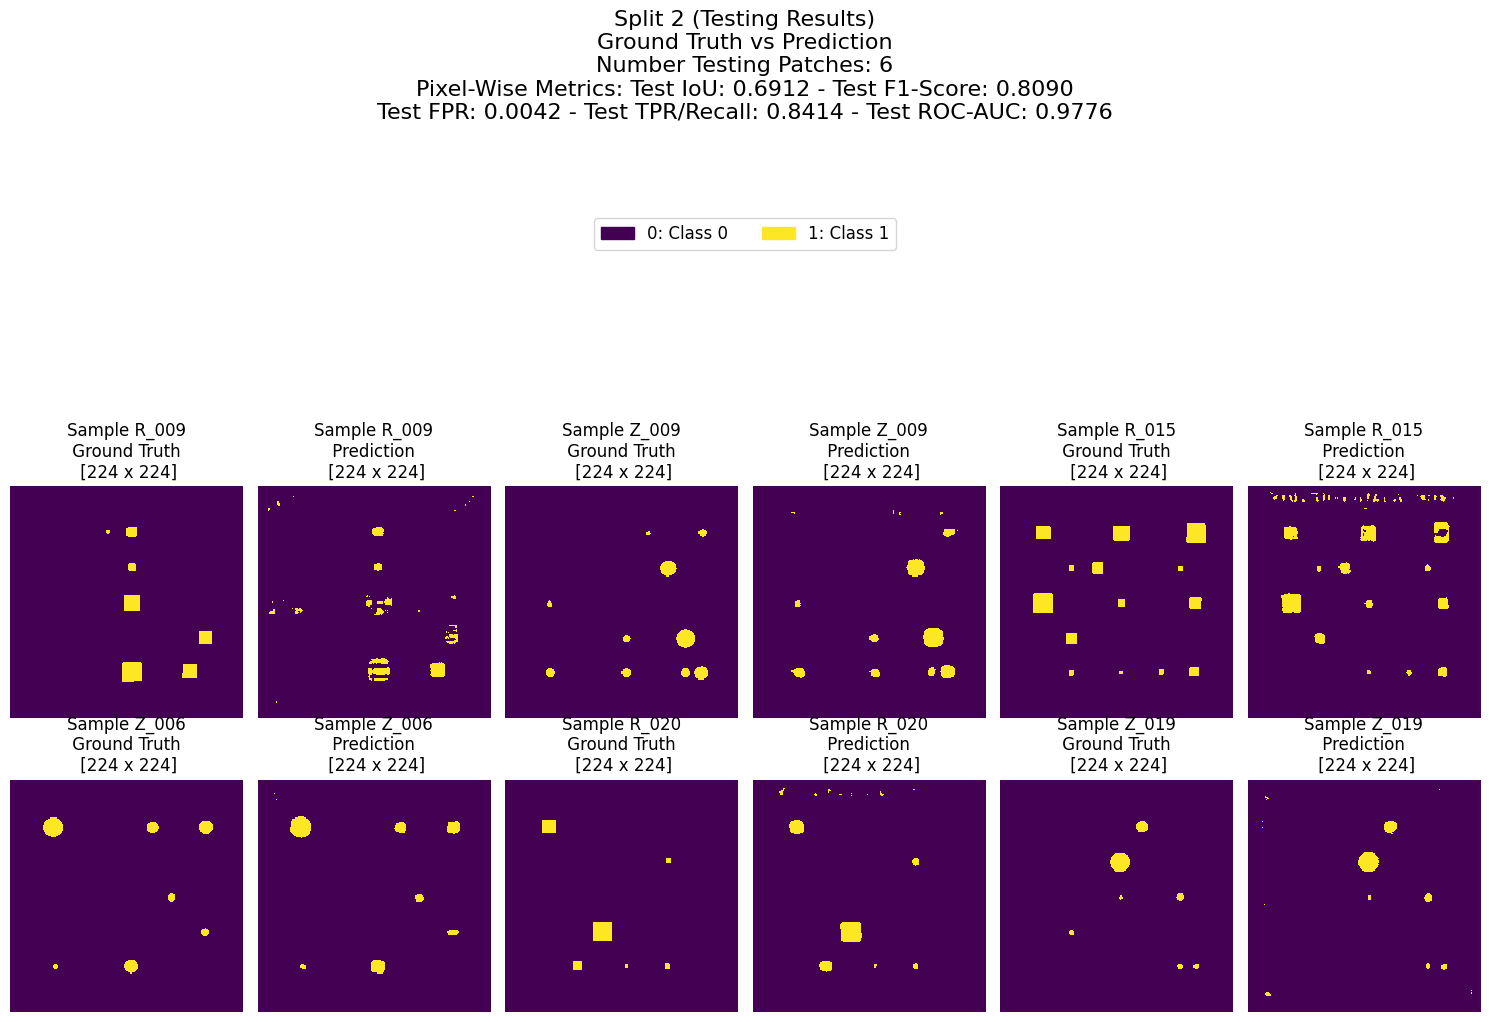

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json
JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json

========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_004', 'R_005', 'R_016', 'Z_002', 'Z_007', 'Z_010'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_004 ...


R_004 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_005 ...


R_005 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_016 ...


R_016 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_002 ...


Z_002 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_007 ...


Z_007 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_010 ...


Z_010 preprocessed (preprocessing took 0.00 seconds)


The JSON file '/home/adrian/AIRT_Seg

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory executions/unet/tuning-train-test/id=171/train_test_split_3/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Testing: |                                                                                                    …

Starting testing epoch...

==> (TESTING) Average Dice Loss (include_background=[False]): 0.193143

==> (TESTING) Average Pixel-Wise Mean IoU (include_background=[False]): 0.690783

==> (TESTING) Average Pixel-Wise Dice Coefficient (include_background=[False]): 0.807284

==> (TESTING) Average Pixel-Wise FPR (include_background=[False]): 0.001854

==> (TESTING) Average TPR/Recall (include_background=[False]): 0.899247

==> (TESTING) Average Precision (include_background=[False]): 0.862730

Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.8072835803031921
     test_fpr_epoch        0.0018539391458034515
     test_loss_epoch        0.1931425780057907
   test_mean_iou_epoch      0.6907827258110046
  test_p

/tmp/ipykernel_98077/2782184094.py:291: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("viridis", num_classes)


Testing results plot for split 3 saved at: executions/unet/tuning-train-test/id=171/train_test_split_3/testing_results/testing_gt_vs_pred_split_3.svg


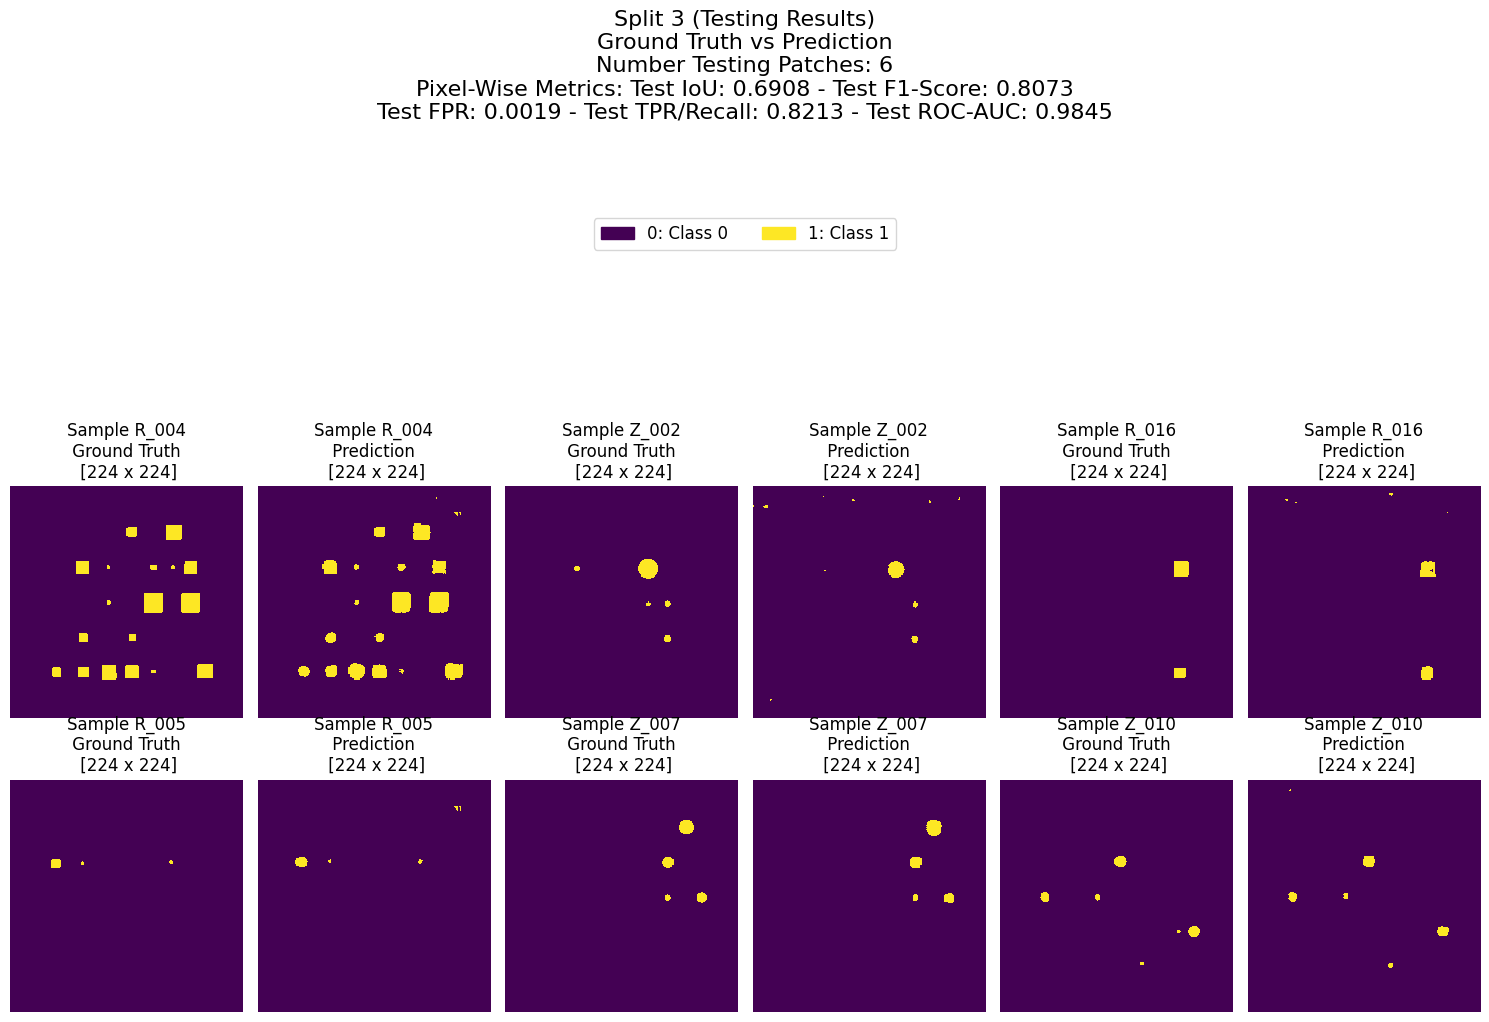

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json
JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json

========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_007', 'R_013', 'R_017', 'Z_003', 'Z_012', 'Z_018'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_007 ...


R_007 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_013 ...


R_013 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample R_017 ...


R_017 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_003 ...


Z_003 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_012 ...


Z_012 preprocessed (preprocessing took 0.00 seconds)


Processing & loading sample Z_018 ...


Z_018 preprocessed (preprocessing took 0.00 seconds)


The JSON file '/home/adrian/AIRT_Seg

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory executions/unet/tuning-train-test/id=171/train_test_split_4/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Testing: |                                                                                                    …

Starting testing epoch...

==> (TESTING) Average Dice Loss (include_background=[False]): 0.243674

==> (TESTING) Average Pixel-Wise Mean IoU (include_background=[False]): 0.654146

==> (TESTING) Average Pixel-Wise Dice Coefficient (include_background=[False]): 0.756614

==> (TESTING) Average Pixel-Wise FPR (include_background=[False]): 0.002015

==> (TESTING) Average TPR/Recall (include_background=[False]): 0.799171

==> (TESTING) Average Precision (include_background=[False]): 0.907123

Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.7566137313842773
     test_fpr_epoch        0.002014832105487585
     test_loss_epoch        0.24367444217205048
   test_mean_iou_epoch      0.6541464924812317
  test_p

/tmp/ipykernel_98077/2782184094.py:291: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("viridis", num_classes)


Testing results plot for split 4 saved at: executions/unet/tuning-train-test/id=171/train_test_split_4/testing_results/testing_gt_vs_pred_split_4.svg


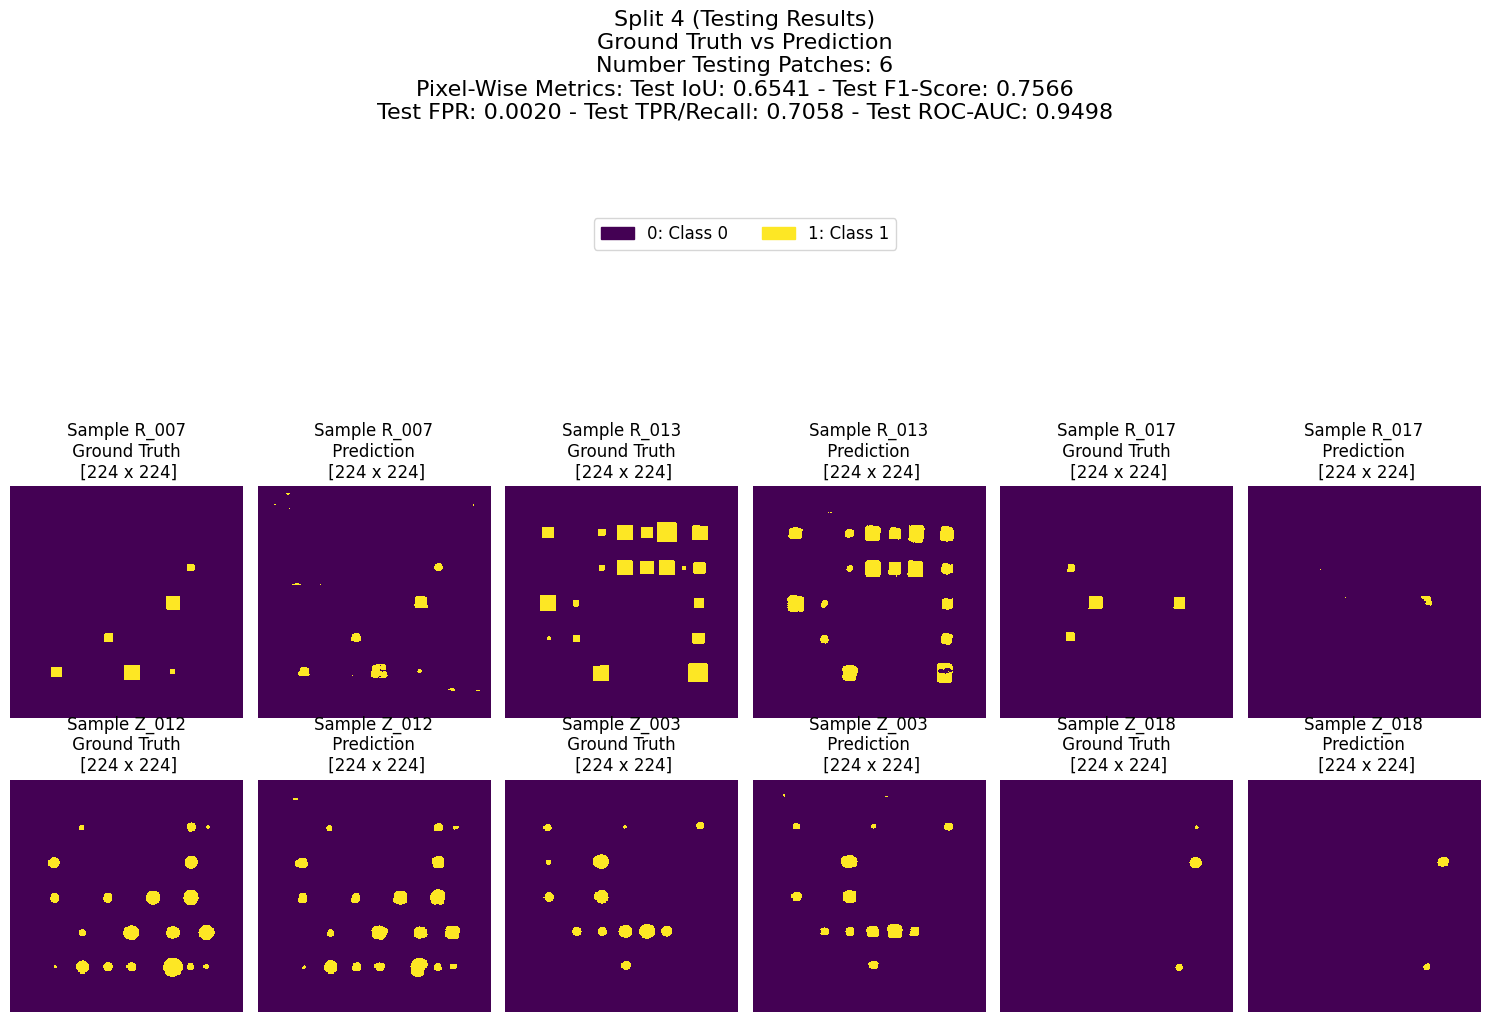

JSON file successfully updated at: executions/unet/tuning-train-test/id=171/new_evaluation_without_training.json

ROC curve saved to: executions/unet/tuning-train-test/id=171/roc_curves.svg


/tmp/ipykernel_98077/2782184094.py:559: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Evaluation (no training) finishes at: 2025-04-12 20:30:42.031594



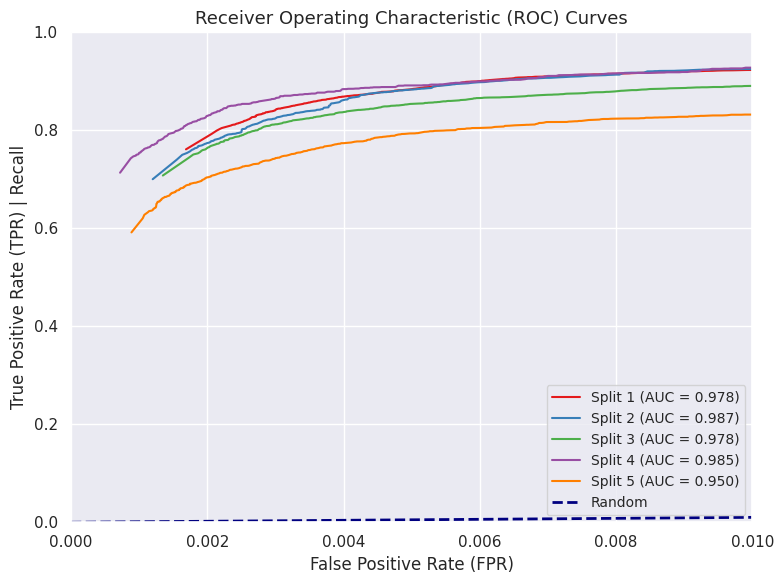

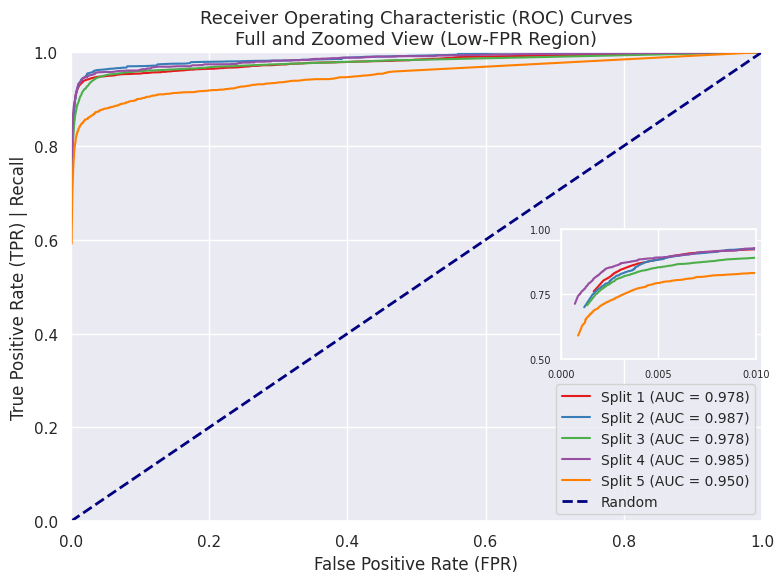

In [14]:
def update_evaluation_summary_json_file(data):
    """
    Overwrites the JSON file on disk with the updated data.

    Parameters:
    - data (dict): The updated dictionary to write to the file.
    """
    try:
        # Ensure the directory exists
        json_path = os.path.join(execution_dir, "new_evaluation_without_training.json")

        # Write the updated data to the file, overwriting it
        with open(json_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)

        print(f"JSON file successfully updated at: {json_path}")

    except Exception as e:
        print(f"An error occurred while updating the JSON file: {e}")

# Generate the evaluation summary
evaluation_summary = {
    "total_execution_time_seconds": None,
    "splits": [],
    "average_testing_iou_thres_0_5": None,
    "average_testing_f1_thres_0_5": None,
    "average_testing_fpr_thres_0_5": None,
    "average_testing_tpr_thres_0_5": None,
    "average_testing_roc_auc": None
}
update_evaluation_summary_json_file(evaluation_summary)

# Measure start training time
start_execution_time = time.time()

print(f"Evaluation (no training) starts at: {datetime.now()}\n")
print()

split_metrics = []

for split_idx, (train_files, test_files) in enumerate(train_test_splits_orginal_copy):

    # Clear the GPU cache between splits
    torch.cuda.empty_cache()

    split_details = {
        "split_index": split_idx,
        "test_samples": None,
        "testing_iou_thres_0_5": None,
        "testing_f1_thres_0_5": None,
        "testing_fpr_thres_0_5": None,
        "testing_tpr_thres_0_5": None,
        "roc_auc": None
    }

    evaluation_summary["splits"].append(split_details)
    update_evaluation_summary_json_file(evaluation_summary)
       
    evaluation_summary["splits"][split_idx]["test_samples"] = list(test_files.keys())

    update_evaluation_summary_json_file(evaluation_summary)    

    ############################################################################################
    ################################### TESTING DATA PREPARATION ###############################
    ############################################################################################
    
    print()
    print(f"{'=' * 10} TESTING DATA PREPARATION {'=' * 10}")
    print()
    
    print(f" SAMPLES: {test_files.keys()}")
    print()
    
    test_dataset = UNET_VGG11_Dataset(
            metadata_dict_with_files_selected=test_files,
            data_dir=DATA_DIR,
            augmentation = False,
            preprocessing_technique = best_trial_config["TRAINING_CONFIG"]["pre_processing_technique"],
            preprocessing_channels = best_trial_config["TRAINING_CONFIG"]["pre_processing_channels"]
    )
       
    test_loader = DataLoader(test_dataset, batch_size=best_trial_config["TRAINING_CONFIG"]["batch_size"], num_workers=NUM_WORKERS)

    ####################################################################################
    ############################## TESTING #############################################
    ####################################################################################
    
    print()
    print(f"{'=' * 10} TESTING STARTS {'=' * 10}")
    print()
            
    # Measure start training time
    start_time = time.time()

    split_dir = os.path.join(execution_dir, f"train_test_split_{split_idx}")

    # Model checkpoint callback    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath=split_dir,
        filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        mode='min'
    )
    
    # Early stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=best_trial_config["TRAINING_CONFIG"]["patience_epochs_early_stopping"],
        mode='min'
    )
    
    # Define logger
    logger = CSVLogger(
        save_dir=split_dir,
        name="",
        version="")
    
    trainer = Trainer(
        max_epochs=best_trial_config["TRAINING_CONFIG"]["max_training_epochs"],
        callbacks=[checkpoint_callback, early_stopping_callback],
        log_every_n_steps=1, # log every n batches
        logger=logger,
        precision="16-mixed"  # Enable FP16 mixed precision
        #accumulate_grad_batches=best_trial_config["TRAINING_CONFIG"]["num_batches_grad_accumulation"],
        #max_time="00:00:05:00"  # Limit TIME (DD:HH:MM:SS format)
    )
    
    # Find all .ckpt files in the directory
    ckpt_files = [filename for filename in os.listdir(split_dir) if filename.endswith('.ckpt')]
    
    # Handle different cases
    if not ckpt_files:
        raise FileNotFoundError(f"No .ckpt file found in the directory: {split_dir}")
    elif len(ckpt_files) > 1:
        raise RuntimeError(f"Multiple .ckpt files found in the directory: {split_dir} -> {ckpt_files}")
    else:
        model_checkpoint_path = os.path.join(split_dir, ckpt_files[0])
        print(f"Found checkpoint: {model_checkpoint_path}")
    
    # Load the best model
    best_model = UNET_VGG11_LightningModel.load_from_checkpoint(
        checkpoint_path=model_checkpoint_path,
        
        optimizer = best_trial_config["TRAINING_CONFIG"]["optimizer"],
        lr_optimizer = best_trial_config["TRAINING_CONFIG"]["lr_optimizer"],
        weight_decay_optimizer = best_trial_config["TRAINING_CONFIG"]["weight_decay_optimizer"]
    )
    
    test_results = trainer.test(best_model, dataloaders=test_loader)[0]
    
    # Measure end training time
    end_time = time.time()
    
    # Calculate and print the elapsed time
    testing_elapsed_time = end_time - start_time
    
    print(f"Testing completed in {testing_elapsed_time // 3600:.0f}h {testing_elapsed_time % 3600 // 60:.0f}m {testing_elapsed_time % 60:.0f}s")
    
    print()
    print(f"{'=' * 10} TESTING FINISHED {'=' * 10}")
    print()


    #############################################################################################
    #############################################################################################
    #############################################################################################    
    
    num_samples = len(best_model.test_predictions_probabilities)

    fpr_all = []
    tpr_all = []
    iou_all = []
    f1_all = []
    roc_auc = None

    # Flatten all tensors, concatenate, convert to NumPy, and get unique values
    all_values = torch.cat([tensor.flatten() for tensor in best_model.test_predictions_probabilities])
    unique_values = np.unique(all_values.cpu().numpy())
    sampled_index_thresholds = np.linspace(0, len(unique_values) - 1, 1000, dtype=int)
    thresholds = unique_values[sampled_index_thresholds]

    # Adding custom 0.5 threshold
    insert_idx = np.searchsorted(thresholds, 0.5)
    thresholds = np.insert(thresholds, insert_idx, 0.5)

    # thresholds = np.linspace(0, 1, 101)

    for thresh in thresholds:
        fpr_list = []
        tpr_list = []
        iou_list = []
        f1_list = []

        for i in range(num_samples):
            pred_binary = (best_model.test_predictions_probabilities[i] >= thresh).int().cpu().numpy().flatten()
            gt_flat = best_model.test_ground_truths[i].int().cpu().numpy().flatten()

            # Safely handle empty classes
            try:
                tn, fp, fn, tp = confusion_matrix(gt_flat, pred_binary, labels=[0, 1]).ravel()
            except ValueError:
                tn = fp = fn = tp = 0

            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
            f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

            fpr_list.append(fpr)
            tpr_list.append(tpr)
            iou_list.append(iou)
            f1_list.append(f1)

        # Average over samples
        fpr_all.append(np.mean(fpr_list))
        tpr_all.append(np.mean(tpr_list))
        iou_all.append(np.mean(iou_list))
        f1_all.append(np.mean(f1_list))

    roc_auc = auc(fpr_all, tpr_all)

    split_metrics.append({
        "thresholds": thresholds,
        "fpr_values": fpr_all,
        "tpr_values": tpr_all,
        "iou_values": iou_all,
        "f1_values": f1_all,
        "roc_auc": roc_auc
    })

    index_0_5 = np.where(split_metrics[-1]["thresholds"] == 0.5)[0][0]

    evaluation_summary["splits"][split_idx]["testing_iou_thres_0_5"] = split_metrics[-1]["iou_values"][index_0_5]
    evaluation_summary["splits"][split_idx]["testing_f1_thres_0_5"] = split_metrics[-1]["f1_values"][index_0_5]
    evaluation_summary["splits"][split_idx]["testing_fpr_thres_0_5"] = split_metrics[-1]["fpr_values"][index_0_5]
    evaluation_summary["splits"][split_idx]["testing_tpr_thres_0_5"] = split_metrics[-1]["tpr_values"][index_0_5]
    evaluation_summary["splits"][split_idx]["roc_auc"] = roc_auc
    
    update_evaluation_summary_json_file(evaluation_summary)

    ####################################################################################
    ############################## PLOTTING TEST RESULTS ###############################
    ####################################################################################

    testing_folder = os.path.join(split_dir, "testing_results")
    os.makedirs(testing_folder, exist_ok=True)
    
    print()
    print(f"{'=' * 10} PLOTTING TEST RESULTS {'=' * 10}")
    print(f"{'=' * 10} GROUND TRUTH VS PREDICTIONS {'=' * 10}")
    print()

    # Control the maximum number of samples to show
    num_samples_to_show = 9
    
    # Adjust the number of samples if fewer samples are available
    available_samples = list(zip(
        best_model.test_sample_ids,
        best_model.test_ground_truths,
        best_model.test_predictions,
        best_model.test_predictions_probabilities
        
    ))
    
    if len(available_samples) < num_samples_to_show:
        print(f"Number of available samples ({len(available_samples)}) is less than requested ({num_samples_to_show}). Plotting all available samples.")
        num_samples_to_show = len(available_samples)
    
    # Randomly sample the data if more samples are available than requested
    plot_samples = random.sample(available_samples, num_samples_to_show)
    
    # Calculate the number of rows needed (3 pairs per row)
    pairs_per_row = 3
    num_rows = (num_samples_to_show + pairs_per_row - 1) // pairs_per_row  # Ceiling division

    # Find unique classes dynamically
    all_classes = set()
    for gt, pred in zip(best_model.test_ground_truths, best_model.test_predictions):
        all_classes.update(torch.unique(gt).tolist())  # Add classes from ground truth
        all_classes.update(torch.unique(pred).tolist())  # Add classes from predictions
    
    # Sort the classes to ensure order
    all_classes = sorted(all_classes)
    
    # Define class labels dynamically (for simplicity, use numeric labels for now)
    class_labels = {cls: f"Class {cls}" for cls in all_classes}
    num_classes = len(class_labels)
    
    # Create a discrete colormap with exactly `num_classes` colors
    colormap = plt.cm.get_cmap("viridis", num_classes)
    
    # Create legend patches using discrete colors from the colormap
    legend_patches = [
        mpatches.Patch(color=colormap(i), label=f"{i}: {label}")
        for i, label in class_labels.items()
    ]
    # Create subplots
    fig, axes = plt.subplots(num_rows, pairs_per_row * 2, figsize=(15, 5 * num_rows))
    
    # If there's only one row, ensure axes is 2D
    if num_rows == 1:
        axes = [axes]
    
    # Flatten axes for easier indexing
    axes = [ax for row_axes in axes for ax in (row_axes if isinstance(row_axes, (list, np.ndarray)) else [row_axes])]
    
    # Plot ground truth and predictions
    for idx, (sample_id, ground_truth, prediction, prediction_prob) in enumerate(plot_samples):
        # Calculate column index (each pair takes two columns)
        col_idx = idx * 2
    
        # Ground truth
        axes[col_idx].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none",
                             vmin=min(all_classes), vmax=max(all_classes))
        axes[col_idx].set_title(f"Sample {sample_id}\n Ground Truth \n [{ground_truth.shape[0]} x {ground_truth.shape[1]}]")
        axes[col_idx].axis("off")

        # Saving ground truth image
        ground_truth_data = ground_truth.cpu().numpy()  # Convert to NumPy array
        ground_truth_colored = apply_colormap_and_normalize(
            ground_truth_data, cmap="viridis", vmin=min(all_classes), vmax=max(all_classes)
        )
        ground_truth_img = Image.fromarray(ground_truth_colored)  # Convert to Pillow Image
        ground_truth_img.save(os.path.join(testing_folder, f"{sample_id}_gt.png"))
    
        # Prediction
        axes[col_idx + 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none",
                                 vmin=min(all_classes), vmax=max(all_classes))
        axes[col_idx + 1].set_title(f"Sample {sample_id}\n Prediction \n [{prediction.shape[0]} x {prediction.shape[1]}]")
        axes[col_idx + 1].axis("off")

        # Saving prediction image
        prediction_data = prediction.cpu().numpy()  # Convert to NumPy array
        prediction_colored = apply_colormap_and_normalize(
            prediction_data, cmap="viridis", vmin=min(all_classes), vmax=max(all_classes)
        )
        prediction_img = Image.fromarray(prediction_colored)  # Convert to Pillow Image
        prediction_img.save(os.path.join(testing_folder, f"{sample_id}_pred.png"))

        prediction_prob.cpu().numpy().astype(np.float32).tofile(os.path.join(testing_folder, f"{sample_id}_pred_prob_map.raw"))
    
    # Hide any unused subplots
    for unused_ax in axes[len(plot_samples) * 2:]:
        unused_ax.axis("off")
    
    # Add legend
    fig.legend(
        handles=legend_patches,
        loc="upper center",  # Places the legend below the plot
        ncol=len(all_classes),
        bbox_to_anchor=(0.5, 0.9),  # Adjusts position below the plot
        fontsize=12
    )

    # Titles for the plots
    plot_title_template = (
        f"Number Testing Patches: {len(test_dataset)}\n"
        f"Pixel-Wise Metrics: Test IoU: { evaluation_summary['splits'][split_idx]['testing_iou_thres_0_5']:.4f} - "
        f"Test F1-Score: {evaluation_summary['splits'][split_idx]['testing_f1_thres_0_5']:.4f}\n"
        f"Test FPR: {evaluation_summary['splits'][split_idx]['testing_fpr_thres_0_5']:.4f} - "
        f"Test TPR/Recall: {evaluation_summary['splits'][split_idx]['testing_tpr_thres_0_5']:.4f} - "
        f"Test ROC-AUC: {evaluation_summary['splits'][split_idx]['roc_auc']:.4f}"
        
    )
    
    # Add title
    fig.suptitle(
        f"Split {split_idx} (Testing Results)\nGround Truth vs Prediction\n" + plot_title_template,
        fontsize=16, y=1.10
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.85])
    result_plot_path = os.path.join(testing_folder, f"testing_gt_vs_pred_split_{split_idx}.svg")
    fig.savefig(result_plot_path, format="svg", bbox_inches="tight")
    print(f"Testing results plot for split {split_idx} saved at: {result_plot_path}")
    plt.show()
    plt.close(fig)  
    
    del best_model
    del trainer
    torch.cuda.empty_cache()
    gc.collect()    

# Measure end training time
end_execution_time = time.time()
    
# Calculate and print the elapsed time
elapsed_execution_time = end_execution_time - start_execution_time

####################################################################################
############################ ANALYSING SPLIT PERFORMANCE ###########################
####################################################################################

testing_iou_thres_0_5_splits = [split["testing_iou_thres_0_5"] for split in sorted(evaluation_summary["splits"], key=lambda x: x["split_index"])]
testing_f1_thres_0_5_splits = [split["testing_f1_thres_0_5"] for split in sorted(evaluation_summary["splits"], key=lambda x: x["split_index"])]
testing_fpr_thres_0_5_splits = [split["testing_fpr_thres_0_5"] for split in sorted(evaluation_summary["splits"], key=lambda x: x["split_index"])]
testing_tpr_thres_0_5_splits = [split["testing_tpr_thres_0_5"] for split in sorted(evaluation_summary["splits"], key=lambda x: x["split_index"])]
testing_roc_auc_splits = [split["roc_auc"] for split in sorted(evaluation_summary["splits"], key=lambda x: x["split_index"])]

# Update the evaluation summary
evaluation_summary["total_execution_time_seconds"] = elapsed_execution_time
evaluation_summary["average_testing_iou_thres_0_5"] = np.mean(testing_iou_thres_0_5_splits)
evaluation_summary["average_testing_f1_thres_0_5"] = np.mean(testing_f1_thres_0_5_splits)
evaluation_summary["average_testing_fpr_thres_0_5"] = np.mean(testing_fpr_thres_0_5_splits)
evaluation_summary["average_testing_tpr_thres_0_5"] = np.mean(testing_tpr_thres_0_5_splits)
evaluation_summary["average_testing_roc_auc"] = np.mean(testing_roc_auc_splits)
update_evaluation_summary_json_file(evaluation_summary)

#############################################################################################################################
############# Obtaining Threshold that Maximizes F1-Score (Code only valid every split has same thresholds) #################
#############################################################################################################################

# # F1-Score 2D matrix: Each row corresponds to the F1-values per split across thresholds
# f1_matrix = np.array([d["f1_values"] for d in split_metrics])
# # Compute average F1-score across splits
# average_f1 = np.mean(f1_matrix, axis=0)

# # IoU 2D matrix: Each row corresponds to the IoU-values per split across thresholds
# iou_matrix = np.array([d["iou_values"] for d in split_metrics])
# # Compute average IoU across splits
# average_iou = np.mean(iou_matrix, axis=0)

# # TPR 2D matrix: Each row corresponds to the TPR-values per split across thresholds
# tpr_matrix = np.array([d["tpr_values"] for d in split_metrics])
# # Compute average TPR across splits
# average_tpr = np.mean(tpr_matrix, axis=0)

# # FPR 2D matrix: Each row corresponds to the FPR-values per split across thresholds
# fpr_matrix = np.array([d["fpr_values"] for d in split_metrics])
# # Compute average FPR across splits
# average_fpr = np.mean(fpr_matrix, axis=0)



# # Get the maximum F1-score and its index
# max_f1_score = np.max(average_f1)
# max_f1_index = np.argmax(average_f1)

# best_threshold = split_metrics[0]["thresholds"][max_f1_index]

# best_threshold_f1 = split_metrics[0]["f1_values"][max_f1_index]
# best_threshold_iou = split_metrics[0]["iou_values"][max_f1_index]
# best_threshold_tpr = split_metrics[0]["tpr_values"][max_f1_index]
# best_threshold_fpr = split_metrics[0]["fpr_values"][max_f1_index]

# print("#"*20)
# print("#"*20)
# print()
# detailed_output = f"Threshold maximizing average F1-score: {best_threshold:.4f}\n" \
#                   f"- F1-score: {best_threshold_f1:.4f}\n" \
#                   f"- IoU:      {best_threshold_iou:.4f}\n" \
#                   f"- TPR:      {best_threshold_tpr:.4f}\n" \
#                   f"- FPR:      {best_threshold_fpr:.4f}\n"
# print(detailed_output)
# print()
# print("#"*20)
# print("#"*20)



###########################################################################
#############              Plotting ROC Curve             #################
###########################################################################

import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime  # just in case it's not imported

# Set Seaborn style (darker grid background)
sns.set(style="darkgrid")
palette = sns.color_palette("Set1", len(split_metrics))  # Colorful and distinct

fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC for each split with a distinct color
for i, (metrics, color) in enumerate(zip(split_metrics, palette)):
    fpr = metrics["fpr_values"]
    tpr = metrics["tpr_values"]
    auc_val = metrics["roc_auc"]

    label = f"Split {i+1} (AUC = {auc_val:.3f})"
    ax.plot(fpr, tpr, label=label, color=color)

# Plot the random baseline
ax.plot([0, 1], [0, 1], linestyle='--', color='navy', linewidth=2, label="Random")

# Format the title and axes to match the example image
ax.set_title("Receiver Operating Characteristic (ROC) Curves", fontsize=13)

ax.set_xlabel("False Positive Rate (FPR)", fontsize=12)
ax.set_ylabel("True Positive Rate (TPR) | Recall", fontsize=12)
ax.set_xlim([0.0, 0.01])
ax.set_ylim([0.0, 1.0])
ax.legend(loc="lower right", fontsize=10)
ax.grid(True)

plt.tight_layout()

# Save plot
plot_path = os.path.join(execution_dir, "roc_curves.svg")
fig.savefig(plot_path, format="svg", bbox_inches="tight")

# Log completion
print()
print(f"ROC curve saved to: {plot_path}")

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

# Use seaborn style
sns.set(style="darkgrid")
palette = sns.color_palette("Set1", len(split_metrics))

# Create main figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC curves for each split
for i, (metrics, color) in enumerate(zip(split_metrics, palette)):
    fpr = metrics["fpr_values"]
    tpr = metrics["tpr_values"]
    auc_val = metrics["roc_auc"]
    label = f"Split {i+1} (AUC = {auc_val:.3f})"
    ax.plot(fpr, tpr, label=label, color=color)

# Plot random baseline
ax.plot([0, 1], [0, 1], linestyle='--', color='navy', linewidth=2, label="Random")

# Titles and labels
ax.set_title("Receiver Operating Characteristic (ROC) Curves\nFull and Zoomed View (Low-FPR Region)", fontsize=13)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=12)
ax.set_ylabel("True Positive Rate (TPR) | Recall", fontsize=12)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.legend(loc="lower right", fontsize=10)

# Add inset axes (zoomed in on low FPR region)
axins = inset_axes(ax, width=1.95, height=1.3, loc="lower center", bbox_to_anchor=(0.85, 0.28),
                   bbox_transform=ax.transAxes, borderpad=2)
for i, (metrics, color) in enumerate(zip(split_metrics, palette)):
    fpr = metrics["fpr_values"]
    tpr = metrics["tpr_values"]
    axins.plot(fpr, tpr, color=color)

# Inset settings
axins.set_xlim(0.0, 0.01)
axins.set_ylim(0.5, 1.0)
axins.set_xticks([0.0, 0.005, 0.01])
axins.set_yticks([0.5, 0.75, 1.0])
axins.tick_params(axis='x', labelsize=7)
axins.tick_params(axis='y', labelsize=7)
axins.tick_params(axis='x', pad=1)  # default is ~4–6
axins.tick_params(axis='y', pad=1)
axins.grid(True)

plt.tight_layout()
# Save plot
plot_path = os.path.join(execution_dir, "roc_curves_with_zoom.svg")
fig.savefig(plot_path, format="svg", bbox_inches="tight")

print(f"Evaluation (no training) finishes at: {datetime.now()}\n")